# Operon analysis
We don't yet have an exhaustive annotation of all operons in _M. buryatense_ but there are a small handful of known operons (curated by Mary Lidstrom, saved in `/data/operon_ncbi_ids,txt`). We examined the spacing between genes within this known set and used this to help us decide how to set the `min_dist` parameter when estimating operons in our main framework. 

## Basic feature file loading/parsing

In [1]:
from Bio import SeqIO

import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sys
sys.path.append('../') # use modules in main directory
import genbank_utils as gu

In [2]:
# genbank files
gbFile_5G = '../data/5GB1c_sequence.gb'
gb_5G = SeqIO.parse(gbFile_5G, "genbank").__next__()

print("___ 5G ____")
print("Genome length:", len(gb_5G.seq), "bps")
print("num features:", len(gb_5G.features))
print("num CDS features:", len([x for x in gb_5G.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_5G.features if x.type=='gene']))
print("num other features:", len([x for x in gb_5G.features if x.type not in ['gene', 'CDS']]))

___ 5G ____
Genome length: 4998879 bps
num features: 8871
num CDS features: 4373
num gene features: 4431
num other features: 67


In [3]:
# get feature coords from genbanks file
feats_5G = gu.get_feature_tuples_from_genbank(gbFile_5G)
feats_5G_filt = [x for x in feats_5G if x[5] not in ['gene']]

feats_5G_filt[:10]

[(0, 1317, 1, 'EQU24_RS00005', 'dnaA', 'CDS'),
 (1502, 2603, 1, 'EQU24_RS00010', '', 'CDS'),
 (3060, 4140, 1, 'EQU24_RS00015', 'recF', 'CDS'),
 (4185, 6600, 1, 'EQU24_RS00020', 'gyrB', 'CDS'),
 (6825, 7062, 1, 'EQU24_RS00025', '', 'CDS'),
 (7098, 7257, 1, 'EQU24_RS00030', '', 'CDS'),
 (7350, 7734, 1, 'EQU24_RS00035', '', 'CDS'),
 (7818, 9075, 1, 'EQU24_RS00040', '', 'CDS'),
 (9071, 10241, 1, 'EQU24_RS00045', '', 'CDS'),
 (10240, 13306, 1, 'EQU24_RS00050', '', 'CDS')]

In [4]:
# feat list indices
LEFT_IDX = 0
RIGHT_IDX = 1
STRAND_IDX = 2
LOCUS_IDX = 3
GENE_IDX = 4
TYPE_IDX = 5

# Curated operon analysis

In [5]:
# load file of curated operons
op_df = pd.read_csv("../data/operon_ncbi_ids.txt", sep='\t')
op_df

,shortd,ncbi_locus,all_genes
0,central_metab_edd,EQU24_RS06110,"EQU24_RS06110,EQU24_RS06105,EQU24_RS06100"
1,central_metab2,EQU24_RS06095,"EQU24_RS06095,EQU24_RS06090,EQU24_RS06085"
2,central_metab3,EQU24_RS06080,"EQU24_RS06080,EQU24_RS06070,EQU24_RS06065"
3,sMMO,EQU24_RS05885,"EQU24_RS05910,EQU24_RS05905,EQU24_RS05900,EQU2..."
4,flagellar_sys,EQU24_RS04900,"EQU24_RS04945,EQU24_RS04940,EQU24_RS04935,EQU2..."
5,serine_cycle,EQU24_RS04570,"EQU24_RS04570,EQU24_RS04565,EQU24_RS04560,EQU2..."
6,PQQ_synth,EQU24_RS02970,"EQU24_RS02970,EQU24_RS02965,EQU24_RS02960,EQU2..."
7,ATP_synthase,EQU24_RS02225,"EQU24_RS02265,EQU24_RS02260,EQU24_RS02255,EQU2..."
8,molyb_form_dh,EQU24_RS01475,"EQU24_RS01475,EQU24_RS01470,EQU24_RS01465,EQU2..."
9,RuMP_cycle1,EQU24_RS21565,"EQU24_RS21565,EQU24_RS21560,EQU24_RS21555,EQU2..."


Mary curatd the above 30 operons as respresentative examples of operons in _M. buryatense_. We analyzed these examples to better understand the typical distance between genes known to be in an operon.

In [6]:
# get list of ids of genes in operons 
all_op_genes = set(",".join(op_df['all_genes'].values).split(','))
# as well as a list of first-genes in operons
op_first_genes = set(op_df['ncbi_locus'].values)

print("Total genes in example operons:",len(all_op_genes))

Total genes in example operons: 175


### Build a dict of all genes in Mary's list to its upstream distance to its nearest neighbor

In [7]:
upd = {} # key: gene, value: upstream_distance

# loop through all features
for i,(g_left,g_right,strand,locus,gene,typee) in enumerate(feats_5G_filt):
    # if this is a gene in one of Mary's operons, get it's upstream dist
    if locus in all_op_genes:
        # if we're on the negative strand, look to the right
        if strand == -1:
            # make sure we're not the very last gene
            if i < len(feats_5G_filt) -1:
                # get the FOLLOWING feature (because on -1 strand)
                upstream_gene = feats_5G_filt[i+1]
                upstream_dist = upstream_gene[LEFT_IDX] - g_right

        # otherwise, we're on the positive strand so look left
        else:
            # make sure we're not the very first gene
            if i != 0:
                # get the PREVIOUS feature (because on +1 strand)
                upstream_gene = feats_5G_filt[i-1]
                upstream_dist = g_left - upstream_gene[RIGHT_IDX]
                
        upd[locus] = upstream_dist
        
# print a few examples from the usptream distance dict
[(x,upd[x]) for x in list(upd.keys())[:10]]

[('EQU24_RS01455', 187),
 ('EQU24_RS01460', -8),
 ('EQU24_RS01465', 19),
 ('EQU24_RS01470', -4),
 ('EQU24_RS01475', 314),
 ('EQU24_RS02225', 115),
 ('EQU24_RS02230', 24),
 ('EQU24_RS02235', 42),
 ('EQU24_RS02240', 42),
 ('EQU24_RS02245', 5)]

## For every example operon, visualize the upstream distance for all genes inside, as well as the upstream distance from the first gene in the operon to its nearest neighor NOT in the operon

In [8]:
# Make a full grid of operon upstream distances
all_dfs = []

for i,row in op_df.iterrows():
    start_gene = row['ncbi_locus']
    other_genes = [x for x in row['all_genes'].split(',') if x !=start_gene]
    start_up_dist = upd[start_gene]
    other_dists = [upd[x] for x in other_genes]

    
    df = pd.DataFrame()
    df['gene'] = row['all_genes'].split(',')
    df['upstream_dist'] = df['gene'].apply(lambda x: upd[x])
    df['start?'] = df['gene'].apply(lambda x: True if x == start_gene else False)
    df['operon'] = row['shortd']
    
    all_dfs.append(df)

all_ops_df = pd.concat(all_dfs)
all_ops_df.head(10)

,gene,upstream_dist,start?,operon
0,EQU24_RS06110,980,True,central_metab_edd
1,EQU24_RS06105,64,False,central_metab_edd
2,EQU24_RS06100,238,False,central_metab_edd
0,EQU24_RS06095,760,True,central_metab2
1,EQU24_RS06090,16,False,central_metab2
2,EQU24_RS06085,100,False,central_metab2
0,EQU24_RS06080,756,True,central_metab3
1,EQU24_RS06070,134,False,central_metab3
2,EQU24_RS06065,-1,False,central_metab3
0,EQU24_RS05910,23,False,sMMO


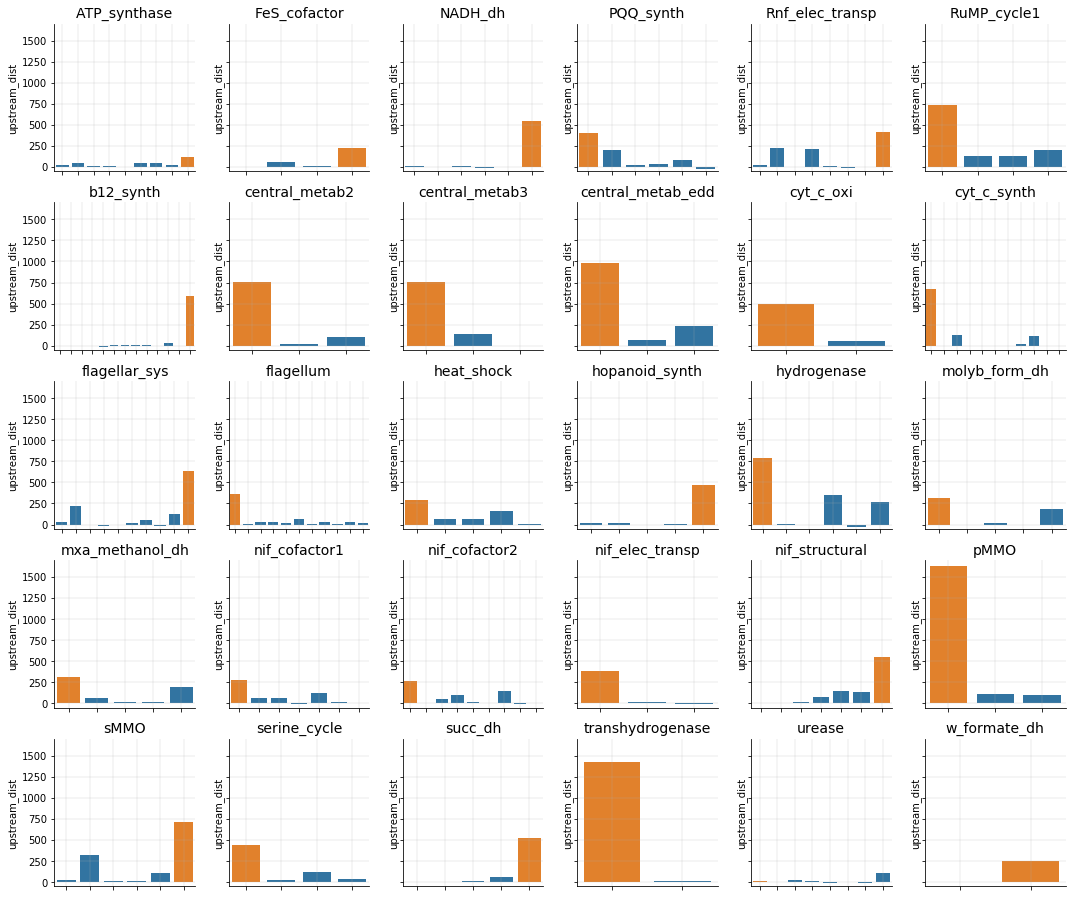

In [9]:
# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=6, ncols=6, sharex=False, sharey='row', figsize=(15,15))
axes_list = [item for sublist in axes for item in sublist] 

for operon, selection in all_ops_df.groupby("operon"):
    ax = axes_list.pop(0)
    sns.barplot(data=selection,x='gene',y='upstream_dist',hue='start?',dodge=False, ax=ax)
    ax.set_title(operon,fontsize=14)
    ax.tick_params(
        right=False,
        top=False
    )
    ax.get_legend().remove()
    ax.grid(linewidth=0.25)
    ax.set_ylim((-50, 1700))
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()


plt.tight_layout()

Each operon has it's leading gene in orange and all internal genes in blue. The height of the bar is the distance between each gene and it's nearest upstream neighbor on the same strand. Overall, leading genes have the biggest upstream distance, though some internal genes (such as those for the "hydrogenase" operon) have large distances (over 250)

### Calculate the average distance between genes inside operons

In [10]:
all_non_start_dists = []
mean_dist_per_operon = []

for i,row in op_df.iterrows():
    start_gene = row['ncbi_locus']
    other_genes = [x for x in row['all_genes'].split(',') if x !=start_gene]
    start_up_dist = upd[start_gene]
    other_dists = [upd[x] for x in other_genes]
    
    # collect averages
    op_ave = np.mean(other_dists)
    all_non_start_dists += other_dists
    mean_dist_per_operon.append(op_ave)
    
    # build dataframe for seaborn
    df = pd.DataFrame()
    df['gene'] = row['all_genes'].split(',')
    df['upstream_dist'] = df['gene'].apply(lambda x: upd[x])
    df['start?'] = df['gene'].apply(lambda x: True if x == start_gene else False)
    

# average over all non-start genes
print("Mean:",np.mean(all_non_start_dists))
print("Median:",np.median(all_non_start_dists))

Mean: 44.675862068965515
Median: 16.0


### Visualize the distibution of upstream distances for all inside-operon genes

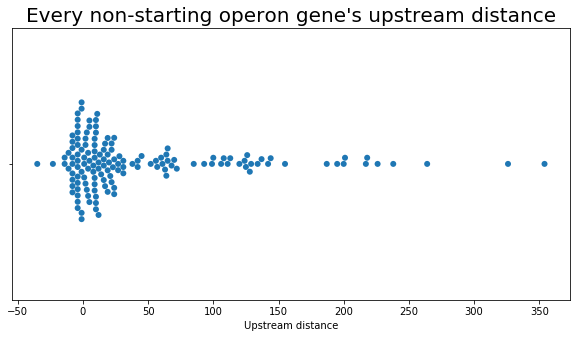

In [11]:
plt.figure(figsize=(10,5))
ax = sns.swarmplot(all_non_start_dists,s=6)
ax.set_xticks(np.arange(-50,400,50))
plt.xlabel("Upstream distance")
plt.title("Every non-starting operon gene's upstream distance",fontsize=20)
plt.show()


In [12]:
# interavtive version with some jitter to simulate swarm plot 
selection = alt.selection_multi(fields=['operon'], bind='legend')

stripplot = alt.Chart(
    all_ops_df[all_ops_df['start?']==False],
).mark_point().encode(
    y=alt.Y(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    x=alt.X(
        'upstream_dist:Q',
        axis=alt.Axis(title="Upstream Distance")),
    color=alt.Color('operon:N',scale=alt.Scale(scheme="sinebow")),
    size=alt.condition(selection, alt.value(100), alt.value(10)),
    tooltip=["operon:N","gene:N", "upstream_dist:Q"],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).properties(
    height=300, 
    width=500,
    title="Every non-starting operon gene's upstream distance"
).add_selection(
        selection,
).interactive()

stripplot

alt.Chart(...)

### Interactive plot!
* Click operon in the legend to highlight points in the scatter plot
    * < Shift > + click to select multiple points in the legend
* Hover over points to see more detail
* Use mouse scroll to zoom in and out

Most of the distribution of upstream distance for internal operon genes is shorter than 50 bases but there are a number of genes that do have larger distances. In particular the, distances for genes in the pMMO operon is 93 and 108. Ultimately we chose 120 as our default value for the miniumum distance genes must be within to be considered "possibly in an operon." 120 includes most genes from this hand curated set but misses a few. 